# Pre-Work

In [33]:
# Load modules
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sns.set()

In [3]:
# Set memory limit on GPU to keep it from freezing up when fitting TensorFlow models later
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], \
                                                                [tf.config.experimental.\
                                                                 VirtualDeviceConfiguration\
                                                                 (memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Inspect Training Data Composition

In [ ]:
os.chdir('../data/raw')

In [80]:
# Load csv file with training set info
df = pd.read_csv('driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


The 'subject' column contains a different ID for each unique person in the training data.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


## Inspect subject composition

In [82]:
# Pull value counts of each subject and put into separate dataframe
subjects = pd.DataFrame(df['subject'].value_counts())
subjects = subjects.reset_index().rename(columns={'index':'subject', 'subject':'counts'})

In [83]:
subjects

,subject,counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


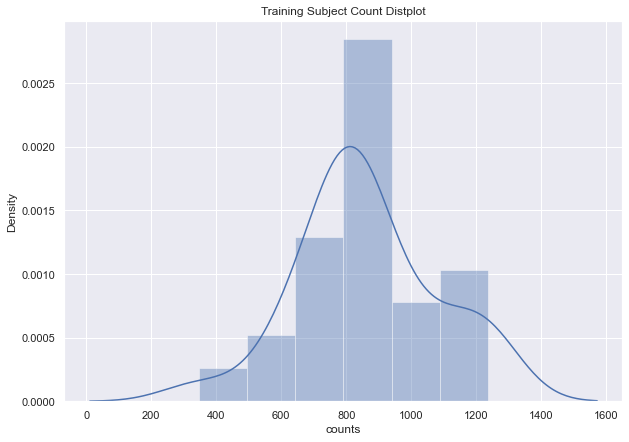

In [84]:
# Plot histogram to visualize spread of training subject frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Distplot')
_ = sns.distplot(subjects.counts)
_ = plt.show()
_ = plt.close()

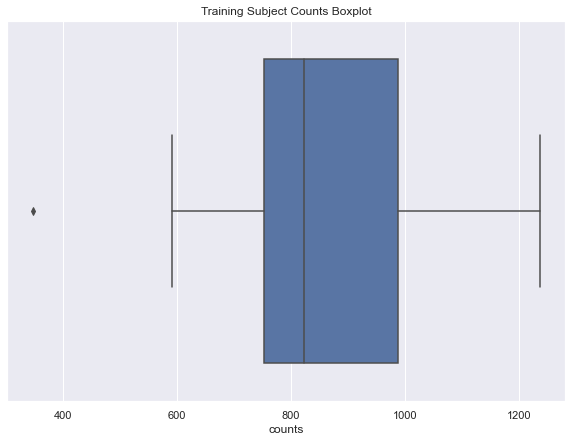

In [85]:
# Plot boxplot to visualize spread of subject frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Boxplot')
_ = sns.boxplot(subjects.counts)
_ = plt.show()
_ = plt.close()

## Inspect class composition

In [86]:
# Do the same thing with classes
classes = pd.DataFrame(df['classname'].value_counts())
classes = classes.reset_index().rename(columns={'index':'classname', 'classname':'counts'})

In [87]:
classes

,classname,counts
0,c0,2489
1,c3,2346
2,c4,2326
3,c6,2325
4,c2,2317
5,c5,2312
6,c1,2267
7,c9,2129
8,c7,2002
9,c8,1911


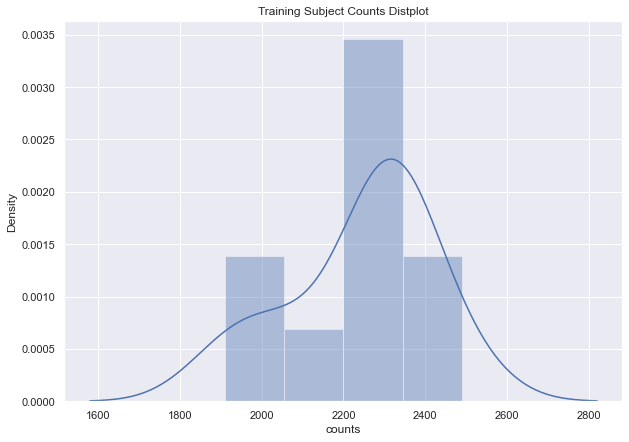

In [88]:
# Plot histogram to visualize spread of training class frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Distplot')
_ = sns.distplot(classes.counts)
_ = plt.show()
_ = plt.close()

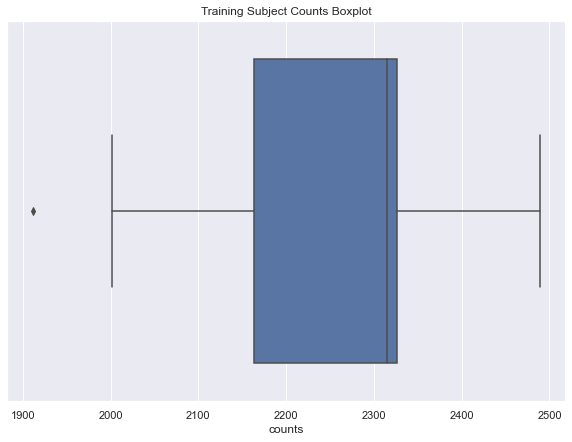

In [89]:
# Plot boxplot to visualize spread of class frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Boxplot')
_ = sns.boxplot(classes.counts)
_ = plt.show()
_ = plt.close()

###### It's clear that there is subject and class imbalance in the training set. This could prove problematic when training the model. Let's take a look and see how the class balance stands on a subject-by-subject basis

## Inspect class composition by subject

In [93]:
# Group aggregate sum class and subject

subbyclass = df.groupby(by=['subject', 'classname']).agg({'img':'count'})
subbyclass = subbyclass.reset_index().rename(columns={'img':'counts'})

In [94]:
subbyclass

,subject,classname,counts
0,p002,c0,76
1,p002,c1,74
2,p002,c2,86
3,p002,c3,79
4,p002,c4,84
...,...,...,...
255,p081,c5,81
256,p081,c6,79
257,p081,c7,77
258,p081,c8,61


In [95]:
subbyclass.loc[subbyclass.subject == 'p002']

,subject,classname,counts
0,p002,c0,76
1,p002,c1,74
2,p002,c2,86
3,p002,c3,79
4,p002,c4,84
5,p002,c5,76
6,p002,c6,83
7,p002,c7,72
8,p002,c8,44
9,p002,c9,51


In [101]:
sublist = subbyclass.subject.unique()

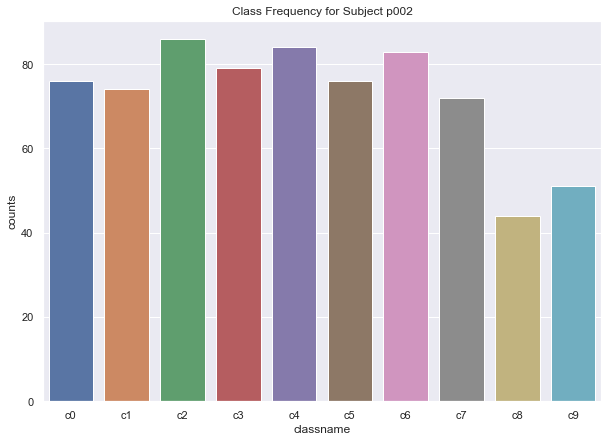

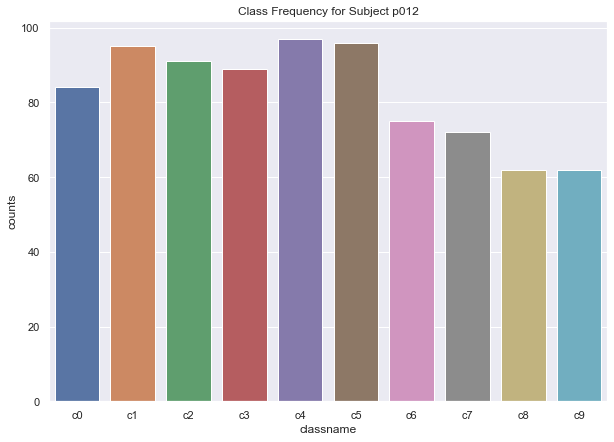

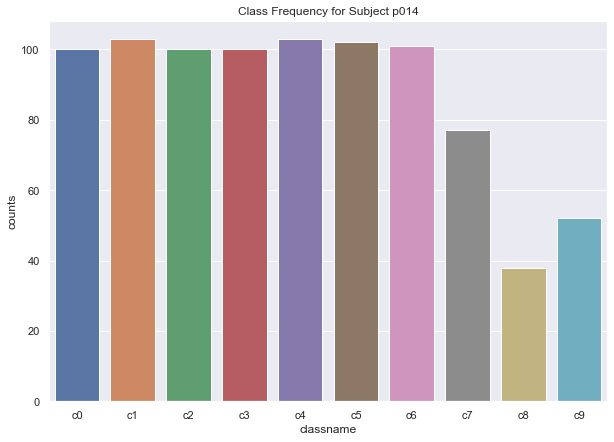

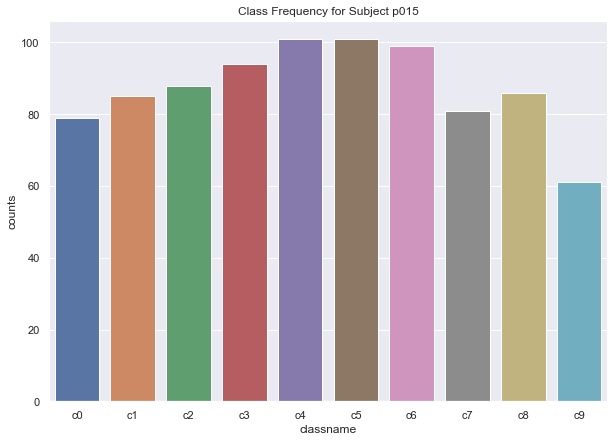

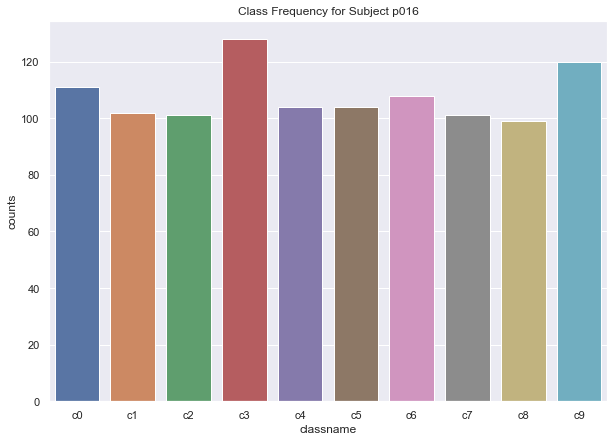

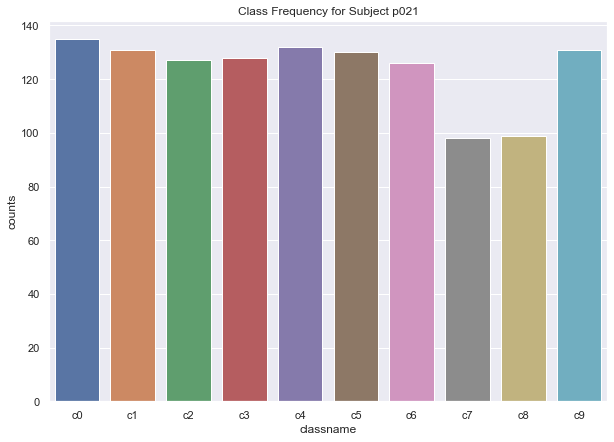

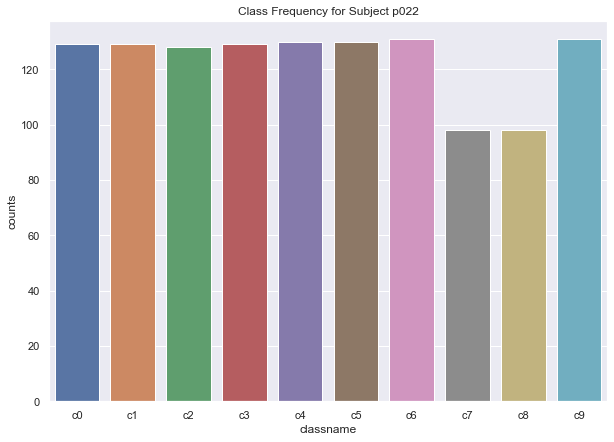

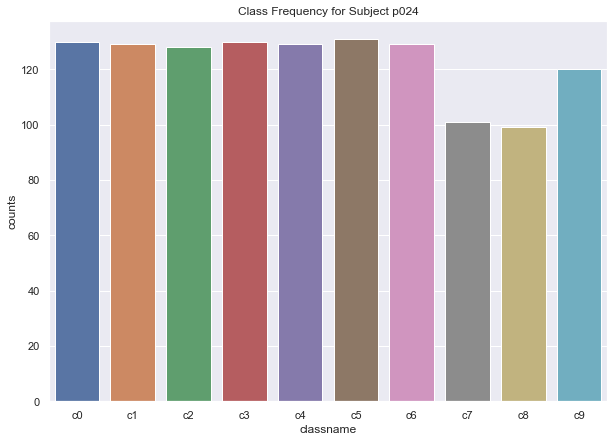

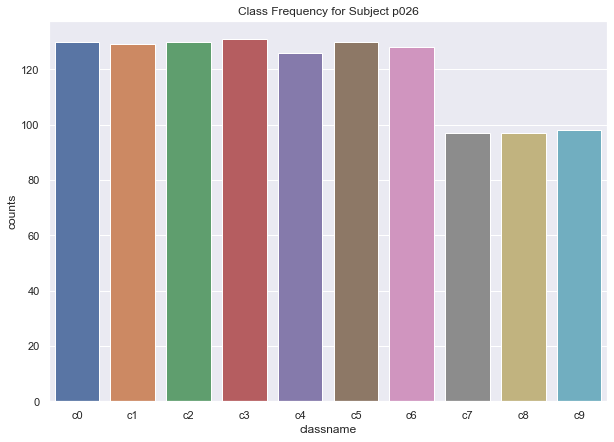

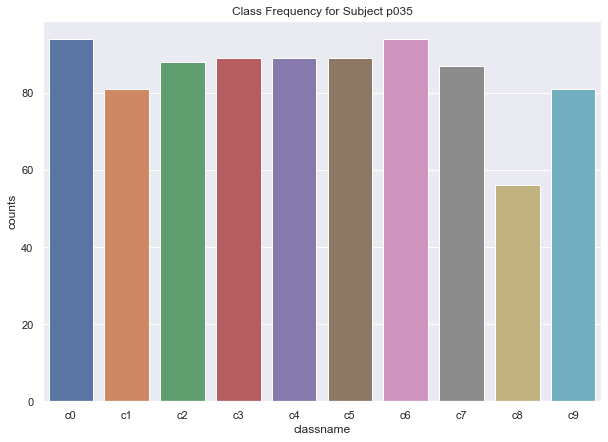

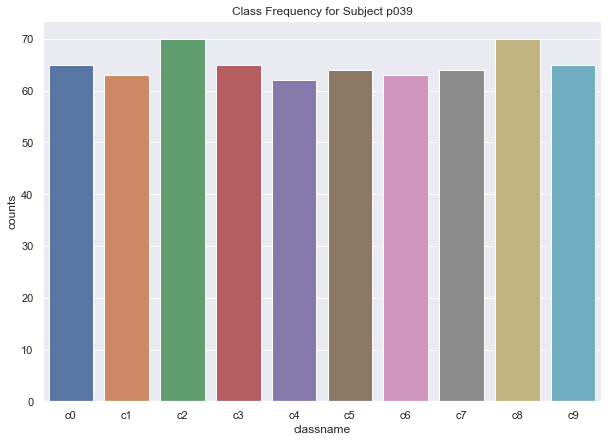

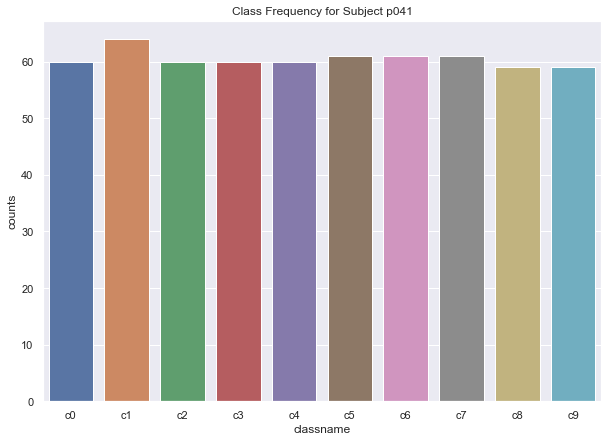

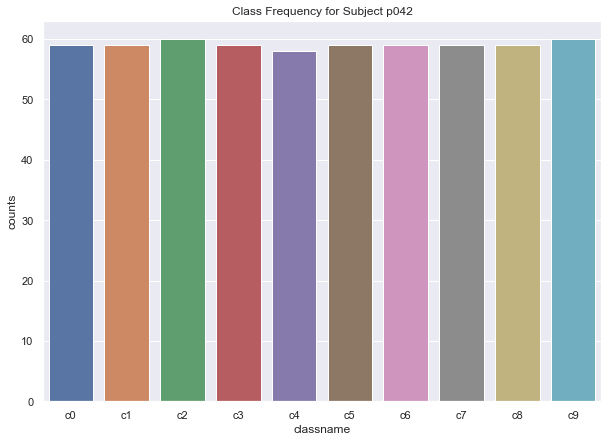

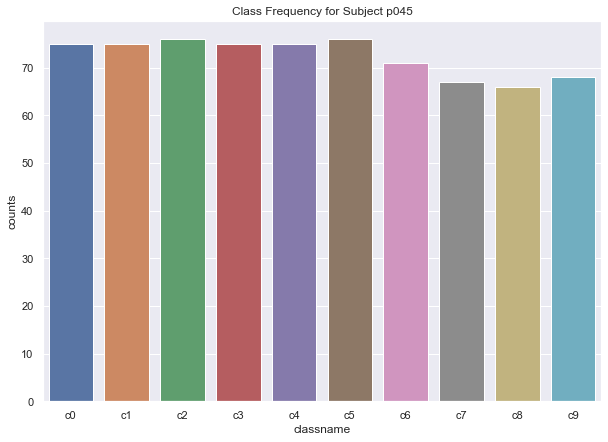

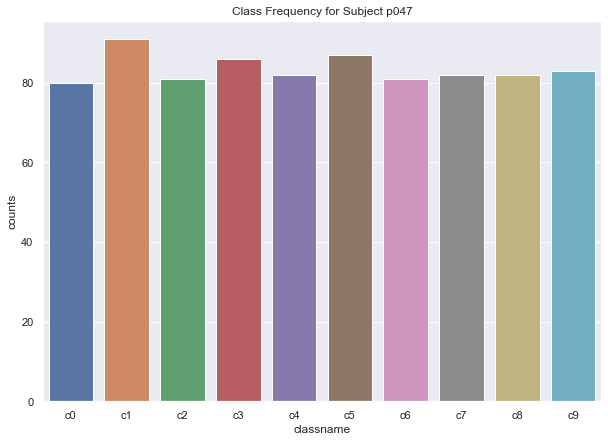

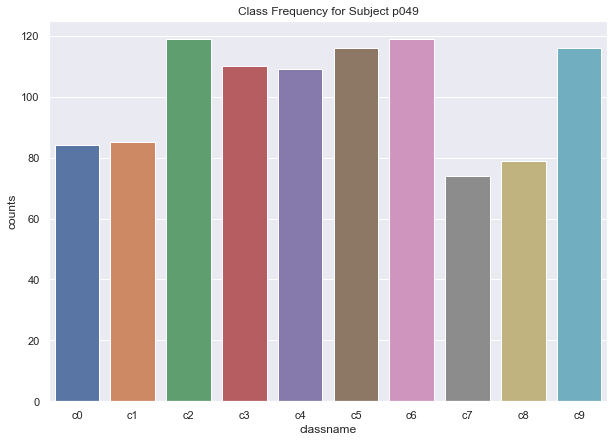

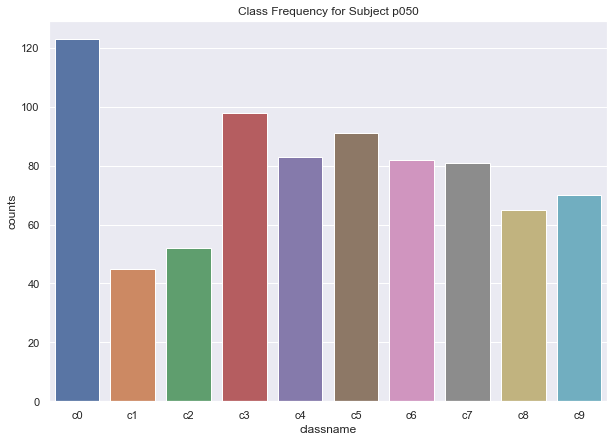

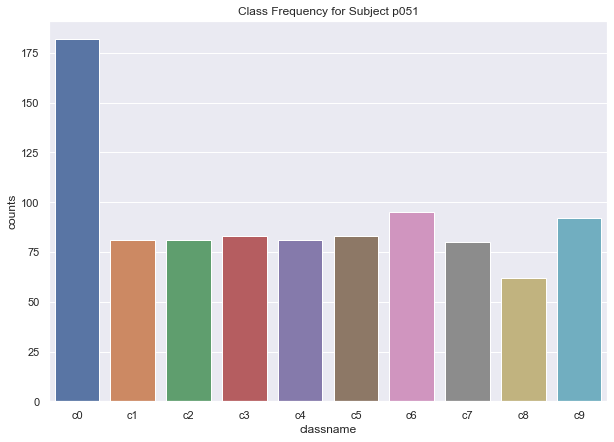

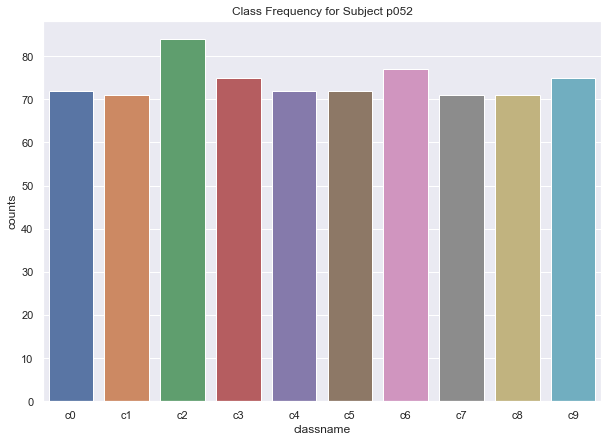

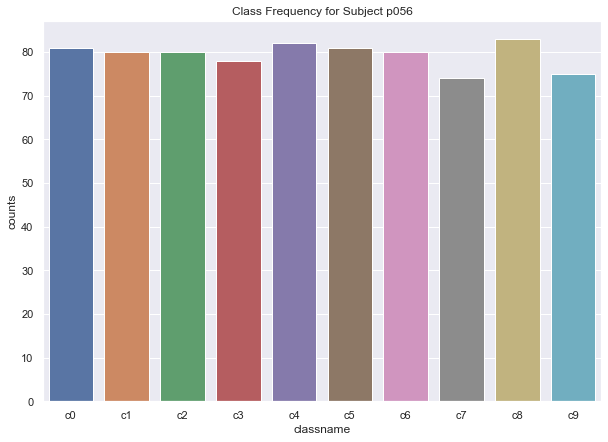

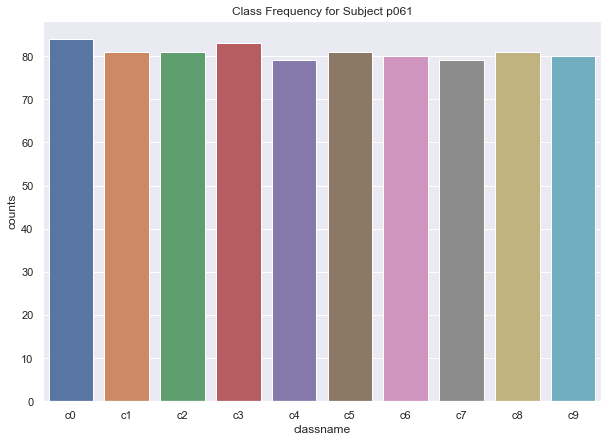

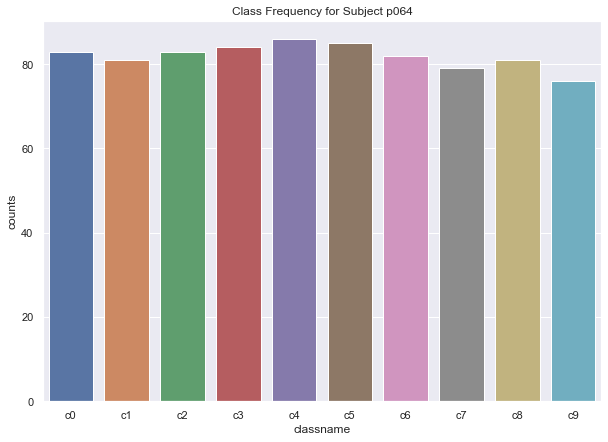

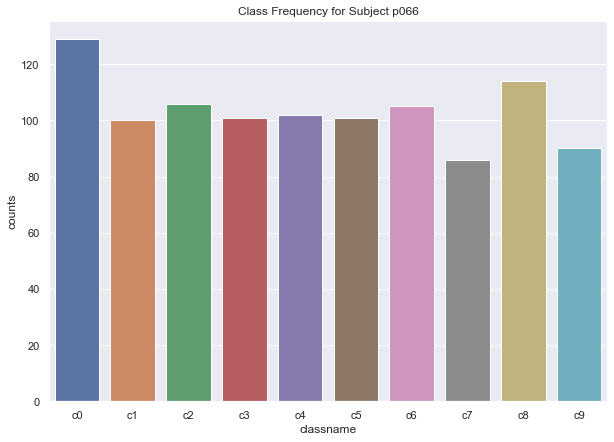

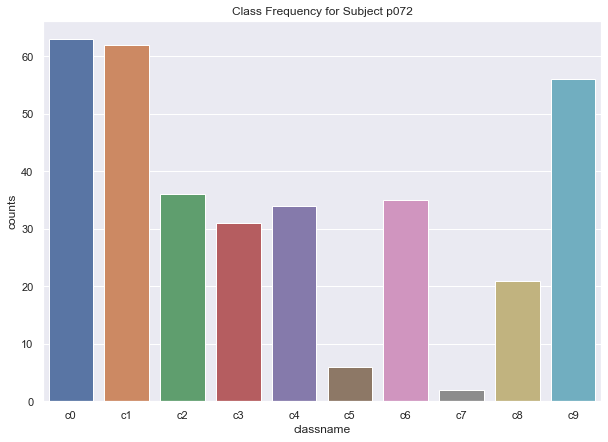

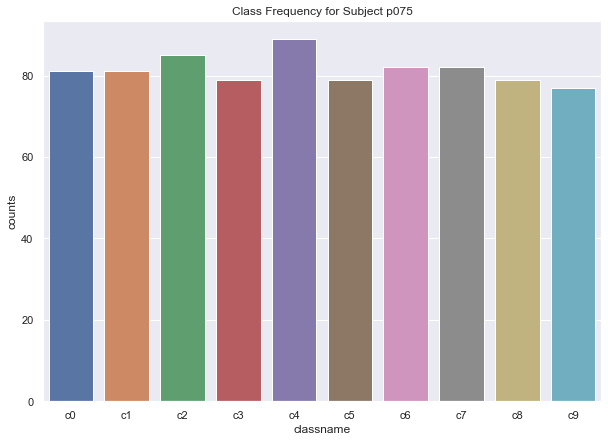

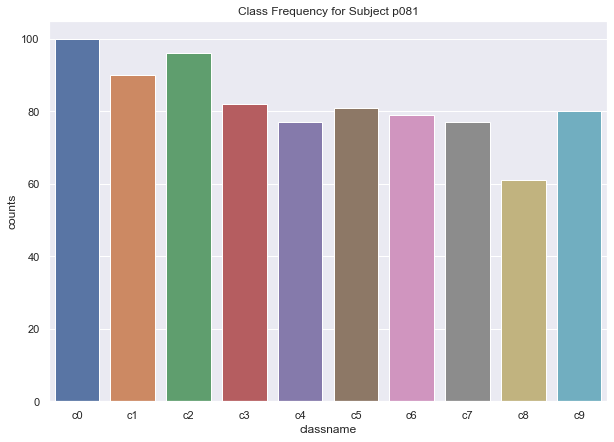

In [102]:
# Plot barplots for each subject to visualize spread of training class frequency

for i in sublist:
    fig = plt.figure(figsize=(10,7))
    _ = plt.title('Class Frequency for Subject ' + str(i))
    _ = sns.barplot(x='classname', y='counts', data=subbyclass.loc[subbyclass.subject == str(i)])
    _ = plt.show()
    _ = plt.close()

Process the dataframe to make a column that generates the filepathway from this parent folder ot each individual file. Then create a function that will generate the crossvalidation train/test splits, with each iteration pulling out one specific subject.

# Datagen

In [20]:
path = '../data/raw/imgs/train'

In [31]:
scores = numpy.empty([5,2])
checkpoint = ModelCheckpoint('weights.hdf5', \
                             mode='max', \
                             monitor='val_accuracy', \
                             save_best_only=True)
callbacks_list=[checkpoint]    

In [32]:
for i in range(5):
    model = Sequential()
    model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(480, 640, 3)))
    model.add(MaxPool2D(30))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    datagen = keras.preprocessing.image.ImageDataGenerator(validation_split=0.3)
    
    train = datagen.flow_from_directory(path, \
                                   target_size=(480, 640), \
                                   subset='training')
    
    val = datagen.flow_from_directory(path, \
                                   target_size=(480, 640), \
                                   subset='validation')
    
    model.fit(train, \
              epochs=3, \
              steps_per_epoch=20, \
              validation_data=val, \
              validation_steps=20, \
              callbacks=callbacks_list)
    
    #print('Evaluating')
    #history = model.evaluate(val)
    #scores[i,0] = history[0]
    #scores[i,1] = history[1]
    

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 20 steps
Epoch 1/3
20/20 [==============================] - 29s 1s/step - loss: 184.2983 - accuracy: 0.1031 - val_loss: 108.1223 - val_accuracy: 0.1328
Epoch 2/3
20/20 [==============================] - 32s 2s/step - loss: 55.8650 - accuracy: 0.1312 - val_loss: 27.2335 - val_accuracy: 0.1984
Epoch 3/3
20/20 [==============================] - 22s 1s/step - loss: 18.8952 - accuracy: 0.2156 - val_loss: 13.3917 - val_accuracy: 0.2609
Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 20 steps
Epoch 1/3
20/20 [==============================] - 25s 1s/step - loss: 145.4389 - accuracy: 0.1016 - val_loss: 73.0403 - val_accuracy: 0.1375
Epoch 2/3
20/20 [==============================] - 21s 1s/step - loss: 41.4